# Collecting Data


Pada tahap ini akan mengimpor seluruh library dari projek

In [6]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

Pada tahap ini kita akan mengambil secara langsung dataset dari yahoo finance terkait saham dari bank mandiri

In [7]:
data = yf.download("BMRI.JK", start="2015-01-01", end="2025-05-25")

[*********************100%***********************]  1 of 1 completed


tahap mengecek data

In [8]:
data

Price,Close,High,Low,Open,Volume
Ticker,BMRI.JK,BMRI.JK,BMRI.JK,BMRI.JK,BMRI.JK
Date,,,,,
2015-01-02,1641.322144,1645.112726,1629.950397,1633.740979,84546800
2015-01-05,1637.531372,1645.112536,1629.950208,1645.112536,33363200
2015-01-06,1626.159790,1641.322119,1618.578626,1629.950372,58600000
2015-01-07,1645.112793,1645.112793,1626.159881,1629.950463,50244400
2015-01-08,1660.274658,1664.065240,1648.902914,1652.693495,63649600
...,...,...,...,...,...
2025-05-19,5525.000000,5575.000000,5400.000000,5450.000000,191440600
2025-05-20,5400.000000,5550.000000,5350.000000,5500.000000,145525700


tahap mengecek tipe data

In [9]:
data.dtypes

,,0
Price,Ticker,
Close,BMRI.JK,float64
High,BMRI.JK,float64
Low,BMRI.JK,float64
Open,BMRI.JK,float64
Volume,BMRI.JK,int64


Data terdapat 2483 baris dan 29 kolom

In [29]:
data.shape

(2483, 29)

# Preprocessing

pada tahapan ini untuk melakukan pengecekan terhadap nilai kosong pada data

In [10]:
data.isnull().sum()

,,0
Price,Ticker,
Close,BMRI.JK,0
High,BMRI.JK,0
Low,BMRI.JK,0
Open,BMRI.JK,0
Volume,BMRI.JK,0


melihat persebaran harga close pada dataset

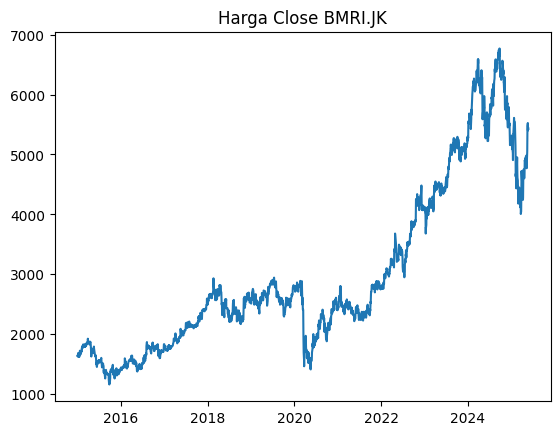

In [11]:
plt.plot(data['Close'])
plt.title('Harga Close BMRI.JK')
plt.show()

feature engineering untuk menghitung rata-rata harga penutupan (Close) dalam jangka waktu tertentu. Fungsi compute_rsi menghitung indikator RSI dengan periode default 14 hari. Menghitung standar deviasi dari harga penutupan selama 20 hari terakhir.

In [12]:
# Moving Average (7 hari dan 30 hari)
data['MA7'] = data['Close'].rolling(window=7).mean()
data['MA30'] = data['Close'].rolling(window=30).mean()

# RSI (Relative Strength Index)
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data['Close'])

# Volatilitas (standar deviasi 20 hari)
data['Volatility'] = data['Close'].rolling(window=20).std()

disini dilakukan ekstraksi informasi waktu (kalender) dari indeks tanggal dalam DataFrame data.

In [13]:
data['Day_of_Week'] = data.index.dayofweek
data['Month'] = data.index.month

Lalu dilakukan pengunduhan data historis indeks IHSG (Indeks Harga Saham Gabungan) dan menyimpan harga penutupannya (Close) ke dalam DataFrame data.

In [14]:
ihsg = yf.download("^JKSE", start="2015-01-01", end="2025-05-25")
data['IHSG_Close'] = ihsg['Close']

[*********************100%***********************]  1 of 1 completed


Feature engineering membentuk kolom baru dengan menghitung dan memprediksi perubahan persentase harga penutupan (Close) dari satu hari ke hari berikutnya

In [15]:
data['Return'] = data['Close'].pct_change().shift(-1)  # Persentase kenaikan

menampilkan data

In [16]:
data

Price,Close,High,Low,Open,Volume,MA7,MA30,RSI,Volatility,Day_of_Week,Month,IHSG_Close,Return
Ticker,BMRI.JK,BMRI.JK,BMRI.JK,BMRI.JK,BMRI.JK,,,,,,,,
Date,,,,,,,,,,,,,
2015-01-02,1641.322144,1645.112726,1629.950397,1633.740979,84546800,NaN,NaN,NaN,NaN,4,1,5242.564941,-0.002310
2015-01-05,1637.531372,1645.112536,1629.950208,1645.112536,33363200,NaN,NaN,NaN,NaN,0,1,5219.791992,-0.006944
2015-01-06,1626.159790,1641.322119,1618.578626,1629.950372,58600000,NaN,NaN,NaN,NaN,1,1,5168.858398,0.011655
2015-01-07,1645.112793,1645.112793,1626.159881,1629.950463,50244400,NaN,NaN,NaN,NaN,2,1,5206.915039,0.009216
2015-01-08,1660.274658,1664.065240,1648.902914,1652.693495,63649600,NaN,NaN,NaN,NaN,3,1,5211.625000,0.015982
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-19,5525.000000,5575.000000,5400.000000,5450.000000,191440600,5126.428571,4791.667733,77.489177,253.550965,0,5,7141.090820,-0.022624
2025-05-20,5400.000000,5550.000000,5350.000000,5500.000000,145525700,5190.714286,4836.590495,69.685039,262.271831,1,5,7094.602051,0.009259


menghapus data bernilai null pada dataset

In [17]:
data = data.dropna()

melihat kolom apa saja yang terbentuk

In [18]:
data.columns

MultiIndex([(      'Close', 'BMRI.JK'),
            (       'High', 'BMRI.JK'),
            (        'Low', 'BMRI.JK'),
            (       'Open', 'BMRI.JK'),
            (     'Volume', 'BMRI.JK'),
            (        'MA7',        ''),
            (       'MA30',        ''),
            (        'RSI',        ''),
            ( 'Volatility',        ''),
            ('Day_of_Week',        ''),
            (      'Month',        ''),
            ( 'IHSG_Close',        ''),
            (     'Return',        '')],
           names=['Price', 'Ticker'])

menyederhanakan bentuk kolom agar mudah diproses

In [19]:
# Gabungkan level Price dan Ticker menjadi satu nama kolom
data.columns = [f"{price}_{ticker}" if ticker else price for price, ticker in data.columns]

melihat update kolomnya berubah nama menjadi apa saja

In [20]:
data.columns

Index(['Close_BMRI.JK', 'High_BMRI.JK', 'Low_BMRI.JK', 'Open_BMRI.JK',
       'Volume_BMRI.JK', 'MA7', 'MA30', 'RSI', 'Volatility', 'Day_of_Week',
       'Month', 'IHSG_Close', 'Return'],
      dtype='object')

Melakukan pemilihan fitur numerik yang akan dinormalisasi, lalu menentukan target akan dari kolom mana, melakukan normalisasi pada fitur terpilih lalu melakukan one hot encode pada kolom kategorikal dan menghapus baris yang null jika ada, kemudian mencetak semua kolom yang ada

In [21]:
numeric_columns = [
    'Open_BMRI.JK', 'High_BMRI.JK', 'Low_BMRI.JK', 'Close_BMRI.JK',
    'Volume_BMRI.JK', 'MA7', 'MA30', 'RSI', 'Volatility', 'IHSG_Close'
]

# Kolom target
target = 'Return'

# Normalisasi fitur
feature_scaler = MinMaxScaler()
data[numeric_columns] = feature_scaler.fit_transform(data[numeric_columns])

# Normalisasi target (Return) secara terpisah
target_scaler = MinMaxScaler()
data['Scaled_Return'] = target_scaler.fit_transform(data[[target]])

# One-hot encoding untuk kolom kategorikal
data = pd.get_dummies(data, columns=['Day_of_Week', 'Month'], prefix=['Day', 'Month'])

# Hapus baris dengan nilai NaN (akibat feature engineering atau shift)
data = data.dropna()

# Tampilkan kolom untuk memastikan
print("Kolom setelah normalisasi dan encoding:", data.columns.tolist())

Kolom setelah normalisasi dan encoding: ['Close_BMRI.JK', 'High_BMRI.JK', 'Low_BMRI.JK', 'Open_BMRI.JK', 'Volume_BMRI.JK', 'MA7', 'MA30', 'RSI', 'Volatility', 'IHSG_Close', 'Return', 'Scaled_Return', 'Day_0', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12']


<ipython-input-21-f789008233c2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[numeric_columns] = feature_scaler.fit_transform(data[numeric_columns])
<ipython-input-21-f789008233c2>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Scaled_Return'] = target_scaler.fit_transform(data[[target]])


melakukan konversi dari false dan true isi kolom day 0 dan seterusnya pada sebelumnya menjadi boolean 0 dan 1 agar bisa diproses oleh sistem

In [22]:
# Asumsi 'data' adalah DataFrame setelah one-hot encoding
# Identifikasi kolom boolean (Day_* dan Month_*)
boolean_columns = [col for col in data.columns if col.startswith('Day_') or col.startswith('Month_')]

# Ubah False/True menjadi 0/1
for col in boolean_columns:  # Perbaikan: ganti 'boolean Benutzercolumns' menjadi 'boolean_columns'
    data[col] = data[col].astype(int)

# Verifikasi perubahan
print("Tipe data setelah konversi:")
print(data[boolean_columns].dtypes)
print("\nContoh data setelah konversi:")
print(data[boolean_columns].head())

Tipe data setelah konversi:
Day_0       int64
Day_1       int64
Day_2       int64
Day_3       int64
Day_4       int64
Month_1     int64
Month_2     int64
Month_3     int64
Month_4     int64
Month_5     int64
Month_6     int64
Month_7     int64
Month_8     int64
Month_9     int64
Month_10    int64
Month_11    int64
Month_12    int64
dtype: object

Contoh data setelah konversi:
            Day_0  Day_1  Day_2  Day_3  Day_4  Month_1  Month_2  Month_3  \
Date                                                                       
2015-02-12      0      0      0      1      0        0        1        0   
2015-02-13      0      0      0      0      1        0        1        0   
2015-02-16      1      0      0      0      0        0        1        0   
2015-02-17      0      1      0      0      0        0        1        0   
2015-02-18      0      0      1      0      0        0        1        0   

            Month_4  Month_5  Month_6  Month_7  Month_8  Month_9  Month_10  \
Date      

# Modelling

Memasuki tahap modelling disini dilakukan pemilihan terhadap fitur dan target

In [23]:
features = [
    'Open_BMRI.JK', 'High_BMRI.JK', 'Low_BMRI.JK', 'Close_BMRI.JK',
    'Volume_BMRI.JK', 'MA7', 'MA30', 'RSI', 'Volatility', 'IHSG_Close'
] + [col for col in data.columns if col.startswith('Day_') or col.startswith('Month_')]
target = 'Scaled_Return'

- Modelling dilakukan dengan model LSTM, diawali dengan Mengubah data time series menjadi format sequence agar bisa diproses oleh model LSTM,
- Setiap input (X) adalah blok dari seq_length baris berturut-turut dari fitur.
Output (y) adalah nilai target (Scaled_Return) pada baris setelah sequence tersebut.
- Lalu dibuat panjang seq nya 30 hari yang berarti model akan dilatih untuk melihat tren pada 30 hari untuk memprediksi return besok
- Lalu splitting dilakukan dengan membagi menjadi 80% data latih dan 20%  data uji
- Lalu dibuat arsitektur LSTM seperti ini :

> Input Layer:

input_shape=(seq_length, len(features))
seq_length: panjang sequence (jumlah hari historis)
len(features): jumlah fitur
> LSTM Layer 1:

50 unit neuron
return_sequences=True: mengirim output ke layer LSTM berikutnya
> Dropout Layer 1:

Untuk mencegah overfitting (dropout rate 20%)
> LSTM Layer 2:

50 unit neuron
return_sequences=False: karena tidak ada LSTM layer berikutnya
> Dropout Layer 2:
Dropout rate 20%

> Output Layer:
Hanya 1 neuron, karena memprediksi 1 nilai (Scaled_Return)

> Loss Function:
mse (Mean Squared Error): cocok untuk regresi numerik\

> Optimizer:
Adam: optimizer adaptif yang umum digunakan

- Lalu model dilatih dengan parameter berikut :
> epochs=50, model akan melewati seluruh data latih sebanyak 50 kali

> batch_size=32: ukuran batch per iterasi pelatihan

> validation_split=0.1: 10% data latih digunakan untuk validasi selama pelatihan

- Lalu melakukan prediksi pada data uji (X_test)
Hasilnya masih dalam skala normalisasi (0–1)

- Mengembalikan ke skala asli dengan inverse transform

- dan diakhiri dengan menghitung performansi model yang telah dilatih dengan metriks mse dan mae

In [24]:
# Buat sequence
def create_sequences(data, seq_length, features, target):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[features].iloc[i:i+seq_length].values)
        y.append(data[target].iloc[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(data, seq_length, features, 'Scaled_Return')

# Bagi data
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Latih model LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, len(features)), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Prediksi pada data pengujian
y_pred = model.predict(X_test)

# Kembalikan y_test dan y_pred ke skala asli
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_unscaled = target_scaler.inverse_transform(y_pred)

# Hitung MAE dan MSE
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)

print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0589 - val_loss: 0.0073
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0099 - val_loss: 0.0039
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0085 - val_loss: 0.0038
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0095 - val_loss: 0.0041
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0072 - val_loss: 0.0048
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0079 - val_loss: 0.0037
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0067 - val_loss: 0.0038
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0074 - val_loss: 0.0043
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0075 - val_loss: 0.0038
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0072 - val_loss: 0.0038
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0070 - val_loss: 0.0036
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0069 - val_l

Membuat visualisasi perbandingan actual dan predict

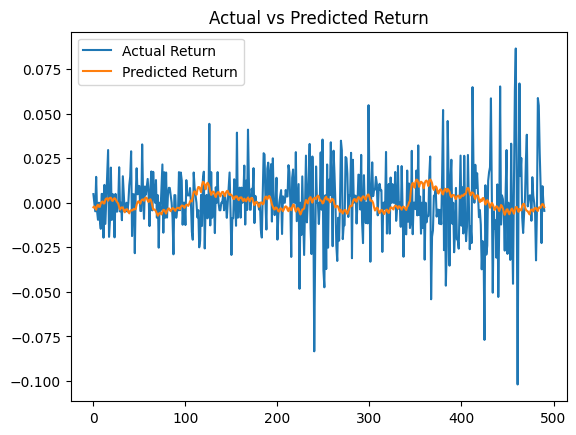

In [25]:
import matplotlib.pyplot as plt
plt.plot(y_test_unscaled, label='Actual Return')
plt.plot(y_pred_unscaled, label='Predicted Return')
plt.legend()
plt.title('Actual vs Predicted Return')
plt.show()

# Hyperparamter tuning

Hyperparameter tuning dilakukan dengan membangun arsitektur LSTM dengan hyperparameter yang bisa diatur, memasukkan semua parameter yang akan diujikan, Semua kombinasi dari parameter ini akan dicoba satu per satu. Lalu Melakukan nested loop untuk mencoba semua kombinasi hyperparameter. Kemudian menyimpan hasil terbaik

In [26]:
# Buat sequence
def create_sequences(data, seq_length, features, target):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[features].iloc[i:i+seq_length].values)
        y.append(data[target].iloc[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(data, seq_length, features, 'Scaled_Return')

# Bagi data
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Definisikan model LSTM dengan hyperparameter yang dituning
def build_lstm_model(units=100, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units, activation='relu', input_shape=(seq_length, len(features)), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units, activation='relu', return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units // 2, activation='relu'))  # Tambah layer ketiga dengan unit lebih kecil
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Parameter untuk tuning
units_list = [100, 128]  # Coba jumlah unit berbeda
dropout_rates = [0.3, 0.4]  # Coba dropout rate berbeda
learning_rates = [0.001, 0.0001]  # Coba learning rate berbeda
batch_sizes = [16, 32]  # Coba batch size berbeda

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Loop untuk mencoba kombinasi hyperparameter
best_mae = float('inf')
best_params = {}
results = []

for units in units_list:
    for dropout_rate in dropout_rates:
        for learning_rate in learning_rates:
            for batch_size in batch_sizes:
                print(f"\nMencoba: units={units}, dropout={dropout_rate}, lr={learning_rate}, batch_size={batch_size}")

                # Bangun dan latih model
                model = build_lstm_model(units=units, dropout_rate=dropout_rate, learning_rate=learning_rate)
                model.fit(X_train, y_train, epochs=100, batch_size=batch_size,
                          validation_split=0.1, callbacks=[early_stopping], verbose=1)

                # Prediksi pada data pengujian
                y_pred = model.predict(X_test)

                # Kembalikan ke skala asli
                y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))
                y_pred_unscaled = target_scaler.inverse_transform(y_pred)

                # Hitung MAE dan MSE
                mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
                mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)

                print(f"MAE: {mae:.6f}, MSE: {mse:.6f}")

                # Simpan hasil
                results.append({
                    'units': units,
                    'dropout_rate': dropout_rate,
                    'learning_rate': learning_rate,
                    'batch_size': batch_size,
                    'mae': mae,
                    'mse': mse
                })

                # Update model terbaik
                if mae < best_mae:
                    best_mae = mae
                    best_params = {
                        'units': units,
                        'dropout_rate': dropout_rate,
                        'learning_rate': learning_rate,
                        'batch_size': batch_size,
                        'mae': mae,
                        'mse': mse
                    }

# Tampilkan hasil terbaik
print("\nHasil Tuning Terbaik:")
print(f"Parameter: {best_params}")
print(f"MAE Terbaik: {best_params['mae']:.6f}")
print(f"MSE Terbaik: {best_params['mse']:.6f}")

# Tampilkan semua hasil
results_df = pd.DataFrame(results)
print("\nSemua Hasil Tuning:")
print(results_df.sort_values(by='mae'))


Mencoba: units=100, dropout=0.3, lr=0.001, batch_size=16
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 0.0332 - val_loss: 0.0038
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 0.0104 - val_loss: 0.0040
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0093 - val_loss: 0.0035
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0089 - val_loss: 0.0044
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0078 - val_loss: 0.0034
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 0.0076 - val_loss: 0.0049
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0072 - val_loss: 0.0041
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0075 - val_loss: 0.0035
Epoch 9/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0067 - val_loss: 0.0036
Epoch 10/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 0.0070 - val_loss: 0.0034
Epoch 11/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0069 - val_loss: 0.0034
Epoch 12/100
111/111 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0608 - val_loss: 0.0044
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0108 - val_loss: 0.0045
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0114 - val_loss: 0.0038
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0101 - val_loss: 0.0040
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0098 - val_loss: 0.0036
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0092 - val_loss: 0.0036
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0084 - val_loss: 0.0044
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 0.0085 - val_loss: 0.0038
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0088 - val_loss: 0.0036
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0088 - val_loss: 0.0044
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0086 - val_loss: 0.0040
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - loss: 0.1110 - val_loss: 0.0083
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0126 - val_loss: 0.0038
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0111 - val_loss: 0.0042
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 0.0098 - val_loss: 0.0038
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0118 - val_loss: 0.0039
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.0101 - val_loss: 0.0038
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 0.0102 - val_loss: 0.0037
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0103 - val_loss: 0.0039
Epoch 9/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 10/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0100 - val_loss: 0.0038
Epoch 11/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0089 - val_loss: 0.0054
Epoch 12/100
111/111 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - loss: 0.1514 - val_loss: 0.0704
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0218 - val_loss: 0.0144
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0152 - val_loss: 0.0048
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0133 - val_loss: 0.0040
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0123 - val_loss: 0.0049
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0124 - val_loss: 0.0055
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.0111 - val_loss: 0.0055
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0116 - val_loss: 0.0045
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0120 - val_loss: 0.0054
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0105 - val_loss: 0.0046
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0112 - val_loss: 0.0043
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.0341 - val_loss: 0.0043
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0105 - val_loss: 0.0045
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0092 - val_loss: 0.0035
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 0.0095 - val_loss: 0.0075
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0083 - val_loss: 0.0044
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 0.0077 - val_loss: 0.0048
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 0.0071 - val_loss: 0.0037
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0068 - val_loss: 0.0036
Epoch 9/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0072 - val_loss: 0.0036
Epoch 10/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0067 - val_loss: 0.0038
Epoch 11/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.0068 - val_loss: 0.0036
Epoch 12/100
111/111 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0649 - val_loss: 0.0039
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0124 - val_loss: 0.0052
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0123 - val_loss: 0.0041
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0103 - val_loss: 0.0036
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.0101 - val_loss: 0.0044
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0108 - val_loss: 0.0051
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0088 - val_loss: 0.0054
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0101 - val_loss: 0.0045
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0091 - val_loss: 0.0059
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0085 - val_loss: 0.0042
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0089 - val_loss: 0.0045
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.0883 - val_loss: 0.0048
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 0.0139 - val_loss: 0.0062
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0129 - val_loss: 0.0072
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.0128 - val_loss: 0.0086
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 0.0119 - val_loss: 0.0095
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0115 - val_loss: 0.0052
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0106 - val_loss: 0.0060
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0119 - val_loss: 0.0073
Epoch 9/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.0106 - val_loss: 0.0046
Epoch 10/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0103 - val_loss: 0.0058
Epoch 11/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0101 - val_loss: 0.0067
Epoch 12/100
111/111 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.1662 - val_loss: 0.0661
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0251 - val_loss: 0.0064
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0174 - val_loss: 0.0040
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0149 - val_loss: 0.0039
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0135 - val_loss: 0.0039
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0136 - val_loss: 0.0065
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0119 - val_loss: 0.0068
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0128 - val_loss: 0.0048
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0120 - val_loss: 0.0056
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.0113 - val_loss: 0.0045
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.0123 - val_loss: 0.0055
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - loss: 0.0489 - val_loss: 0.0040
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.0110 - val_loss: 0.0036
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - loss: 0.0090 - val_loss: 0.0036
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 0.0092 - val_loss: 0.0052
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 0.0096 - val_loss: 0.0038
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0084 - val_loss: 0.0035
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.0080 - val_loss: 0.0035
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0071 - val_loss: 0.0042
Epoch 9/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 0.0084 - val_loss: 0.0037
Epoch 10/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.0074 - val_loss: 0.0045
Epoch 11/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.0070 - val_loss: 0.0037
Epoch 12/100
111/111 ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - loss: 0.0429 - val_loss: 0.0039
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.0090 - val_loss: 0.0041
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 0.0098 - val_loss: 0.0037
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 0.0087 - val_loss: 0.0051
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0091 - val_loss: 0.0037
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - loss: 0.0077 - val_loss: 0.0036
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 0.0087 - val_loss: 0.0038
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 0.0065 - val_loss: 0.0035
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - loss: 0.0073 - val_loss: 0.0035
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - loss: 0.0070 - val_loss: 0.0039
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 0.0071 - val_loss: 0.0038
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - loss: 0.0800 - val_loss: 0.0097
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 0.0129 - val_loss: 0.0042
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0100 - val_loss: 0.0042
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.0095 - val_loss: 0.0039
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0087 - val_loss: 0.0037
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0095 - val_loss: 0.0037
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 0.0086 - val_loss: 0.0039
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.0087 - val_loss: 0.0042
Epoch 9/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 0.0086 - val_loss: 0.0036
Epoch 10/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 0.0087 - val_loss: 0.0040
Epoch 11/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 0.0079 - val_loss: 0.0039
Epoch 12/100
111/111 ━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - loss: 0.1446 - val_loss: 0.0096
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0155 - val_loss: 0.0052
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - loss: 0.0129 - val_loss: 0.0042
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 0.0113 - val_loss: 0.0040
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0108 - val_loss: 0.0042
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.0106 - val_loss: 0.0038
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.0098 - val_loss: 0.0040
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 0.0100 - val_loss: 0.0037
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0099 - val_loss: 0.0037
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - loss: 0.0094 - val_loss: 0.0037
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0096 - val_loss: 0.0037
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - loss: 0.0283 - val_loss: 0.0037
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.0094 - val_loss: 0.0039
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.0113 - val_loss: 0.0037
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - loss: 0.0083 - val_loss: 0.0036
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0073 - val_loss: 0.0057
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 0.0074 - val_loss: 0.0042
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0076 - val_loss: 0.0041
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0075 - val_loss: 0.0041
Epoch 9/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 0.0065 - val_loss: 0.0036
Epoch 10/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0070 - val_loss: 0.0036
Epoch 11/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0066 - val_loss: 0.0035
Epoch 12/100
111/111 ━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - loss: 0.0550 - val_loss: 0.0043
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0106 - val_loss: 0.0035
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - loss: 0.0106 - val_loss: 0.0037
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 0.0111 - val_loss: 0.0035
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - loss: 0.0089 - val_loss: 0.0043
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - loss: 0.0086 - val_loss: 0.0040
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - loss: 0.0085 - val_loss: 0.0041
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.0086 - val_loss: 0.0044
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 0.0089 - val_loss: 0.0038
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 0.0076 - val_loss: 0.0040
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.0090 - val_loss: 0.0038
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 0.0936 - val_loss: 0.0044
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 0.0130 - val_loss: 0.0041
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0124 - val_loss: 0.0045
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0114 - val_loss: 0.0041
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.0123 - val_loss: 0.0043
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0112 - val_loss: 0.0054
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.0097 - val_loss: 0.0048
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0088 - val_loss: 0.0044
Epoch 9/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0091 - val_loss: 0.0046
Epoch 10/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 0.0101 - val_loss: 0.0037
Epoch 11/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0085 - val_loss: 0.0048
Epoch 12/100
111/111 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 0.1575 - val_loss: 0.0080
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 0.0193 - val_loss: 0.0054
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 0.0153 - val_loss: 0.0041
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - loss: 0.0129 - val_loss: 0.0043
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0126 - val_loss: 0.0053
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - loss: 0.0118 - val_loss: 0.0060
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.0128 - val_loss: 0.0054
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 0.0123 - val_loss: 0.0053
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.0130 - val_loss: 0.0040
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 0.0105 - val_loss: 0.0046
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0107 - val_loss: 0.0059
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s

Melatih model LSTM dengan parameter terbaik hasil hyperparameter tuning

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - loss: 0.0430 - val_loss: 0.0037
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 0.0121 - val_loss: 0.0037
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0104 - val_loss: 0.0043
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 0.0095 - val_loss: 0.0035
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0091 - val_loss: 0.0039
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0093 - val_loss: 0.0047
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.0081 - val_loss: 0.0056
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0083 - val_loss: 0.0053
Epoch 9/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0079 - val_loss: 0.0035
Epoch 10/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0075 - val_loss: 0.0039
Epoch 11/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0067 - val_loss: 0.0039
Epoch 12/100
111/111 ━━━━━━━━━━━━━━━━━━━

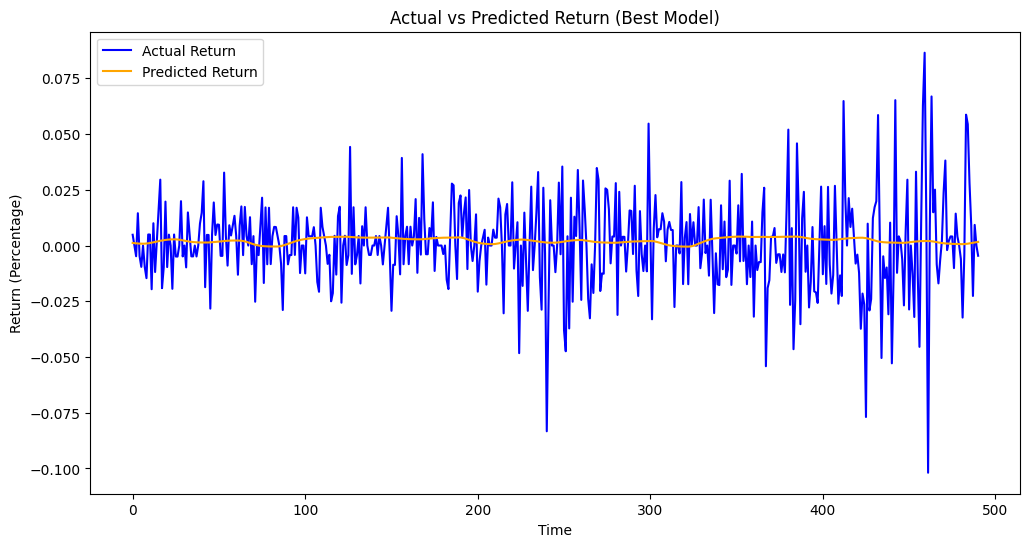

In [27]:
# Asumsi 'data', 'features', dan 'target_scaler' sudah didefinisikan
# Pastikan data sudah dinormalisasi dan one-hot encoded
# Contoh pengingat normalisasi (jalankan jika belum):
"""
from sklearn.preprocessing import MinMaxScaler
numeric_columns = [
    'Open_BMRI.JK', 'High_BMRI.JK', 'Low_BMRI.JK', 'Close_BMRI.JK',
    'Volume_BMRI.JK', 'MA7', 'MA30', 'RSI', 'Volatility', 'IHSG_Close'
]
feature_scaler = MinMaxScaler()
data[numeric_columns] = feature_scaler.fit_transform(data[numeric_columns])
target_scaler = MinMaxScaler()
data['Scaled_Return'] = target_scaler.fit_transform(data[['Return']])
data = pd.get_dummies(data, columns=['Day_of_Week', 'Month'], prefix=['Day', 'Month'], dtype=int)
data = data.dropna()
features = numeric_columns + [col for col in data.columns if col.startswith('Day_') or col.startswith('Month_')]
"""

# Buat sequence
def create_sequences(data, seq_length, features, target):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[features].iloc[i:i+seq_length].values)
        y.append(data[target].iloc[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(data, seq_length, features, 'Scaled_Return')

# Bagi data
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Bangun model dengan parameter terbaik
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(seq_length, len(features)), return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(50, activation='relu'))  # Layer ketiga dengan unit lebih kecil
model.add(Dropout(0.4))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Early stopping untuk mencegah overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Latih model
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1,
          callbacks=[early_stopping], verbose=1)

# Prediksi pada data pengujian
y_pred = model.predict(X_test)

# Kembalikan ke skala asli
y_test_unscaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_unscaled = target_scaler.inverse_transform(y_pred)

# Hitung MAE dan MSE
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
mse = mean_squared_error(y_test_unscaled, y_pred_unscaled)

print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Squared Error (MSE): {mse:.6f}")

# Visualisasi prediksi vs aktual
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled, label='Actual Return', color='blue')
plt.plot(y_pred_unscaled, label='Predicted Return', color='orange')
plt.title('Actual vs Predicted Return (Best Model)')
plt.xlabel('Time')
plt.ylabel('Return (Percentage)')
plt.legend()
plt.show()

# Inference

Melakukan inference untuk menguji model agar memprediksi return untuk 10 hari kedepan

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

<ipython-input-28-5516b960c2d2>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_sequence[-1, 0] = pred  # Update kolom pertama (misalnya, Scaled_Return)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

Prediksi Return Harian untuk 10 Hari ke Depan (%):
Hari 1: 0.001623%
Hari 2: 0.001710%
Hari 3: 0.001780%
Hari 4: 0.001808%
Hari 5: 0.001789%
Hari 6: 0.001731%
Hari 7: 0.001626%
Hari 8: 0.001489%
Hari 9: 0.001359%
Hari 10: 0.001237%


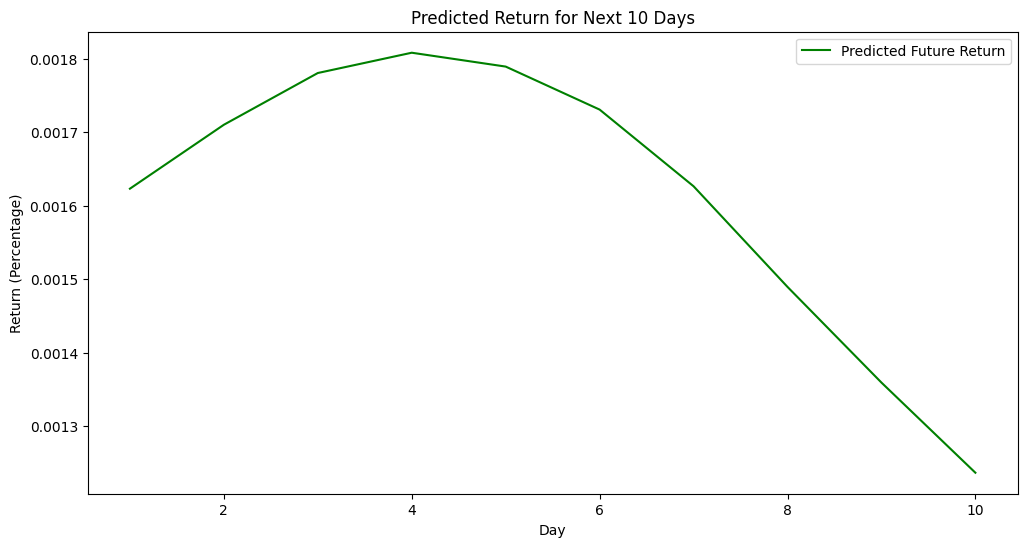

In [28]:
# Prediksi Return untuk 10 hari ke depan
n_future_days = 10
future_returns = []
current_sequence = X[-1].copy()  # Ambil sequence terakhir dari data

for _ in range(n_future_days):
    pred = model.predict(current_sequence.reshape(1, seq_length, len(features)))
    future_returns.append(pred[0, 0])
    current_sequence = np.roll(current_sequence, -1, axis=0)
    current_sequence[-1, 0] = pred  # Update kolom pertama (misalnya, Scaled_Return)

# Kembalikan prediksi ke skala asli
future_returns_unscaled = target_scaler.inverse_transform(np.array(future_returns).reshape(-1, 1))

# Tampilkan prediksi
print("\nPrediksi Return Harian untuk 10 Hari ke Depan (%):")
for i, ret in enumerate(future_returns_unscaled):
    print(f"Hari {i+1}: {ret[0]:.6f}%")

# Visualisasi prediksi masa depan
plt.figure(figsize=(12, 6))
plt.plot(range(1, n_future_days + 1), future_returns_unscaled, label='Predicted Future Return', color='green')
plt.title('Predicted Return for Next 10 Days')
plt.xlabel('Day')
plt.ylabel('Return (Percentage)')
plt.legend()
plt.show()